## Tutorial: Defining a new test-time loss and optimizing code.

![TextGrad](https://github.com/vinid/data/blob/master/logo_full.png?raw=true)

An autograd engine -- for textual gradients!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zou-group/TextGrad/blob/main/examples/notebooks/Prompt-Optimization.ipynb)
[![GitHub license](https://img.shields.io/badge/License-MIT-blue.svg)](https://lbesson.mit-license.org/)
[![Arxiv](https://img.shields.io/badge/arXiv-2406.07496-B31B1B.svg)](https://arxiv.org/abs/2406.07496)
[![Documentation Status](https://readthedocs.org/projects/textgrad/badge/?version=latest)](https://textgrad.readthedocs.io/en/latest/?badge=latest)
[![PyPI - Python Version](https://img.shields.io/pypi/pyversions/textgrad)](https://pypi.org/project/textgrad/)
[![PyPI](https://img.shields.io/pypi/v/textgrad)](https://pypi.org/project/textgrad/)

**Objectives:**

* In this tutorial, we will do a quick walkthrough around how to define a simple test time loss in TextGrad and optimize a variable of interest.

**Requirements:**

* You need to have an OpenAI API key to run this tutorial. This should be set as an environment variable as OPENAI_API_KEY.

We first define some utilities and a set of test cases.

In [1]:
!pip install textgrad # you might need to restart the notebook after installing textgrad

import textgrad as tg
import random
import time

### Utilities to run the code, and test cases

In [2]:
# We'll use below utilities to run a python function.
from IPython.core.interactiveshell import InteractiveShell

def run_function_in_interpreter(func_code):
    raise Exception("This function will run the code returned by GPT-4o. Remove this if you'd like to run the code!")
    interpreter = InteractiveShell.instance()
    
    interpreter.run_cell(func_code, store_history=False, silent=True)
    
    func_name = func_code.split("def ")[1].split("(")[0].strip()
    func = interpreter.user_ns[func_name]
    
    return func


def test_longest_increasing_subsequence(fn):
    nums = [10, 22, 9, 33, 21, 50, 41, 60]
    assert fn(nums) == 5

    nums = [7, 2, 1, 3, 8, 4, 9, 6, 5]
    assert fn(nums) == 4

    nums = [5, 4, 3, 2, 1]
    assert fn(nums) == 1

    nums = [1, 2, 3, 4, 5]
    assert fn(nums) == 5

    nums = [3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5]
    assert fn(nums) == 4

    nums = [10, 9, 2, 5, 3, 7, 101, 18]
    assert fn(nums) == 4

    nums = [0, 8, 4, 12, 2, 10, 6, 14, 1, 9, 5, 13, 3, 11, 7, 15]
    assert fn(nums) == 6

    nums = [7, 7, 7, 7, 7, 7, 7]
    assert fn(nums) == 1

    nums = [20, 25, 47, 35, 56, 68, 98, 101, 212, 301, 415, 500]
    assert fn(nums) == 11

    nums = [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
    assert fn(nums) == 1

    print("All test cases passed!")

## Problem: Improving a code snippet.
We have a simple problem, and an initial solution that does not run quite fast. We first test this solution and look at the wall clock time.

In [3]:
problem_text = """Longest Increasing Subsequence (LIS)

Problem Statement:
Given a sequence of integers, find the length of the longest subsequence that is strictly increasing. A subsequence is a sequence that can be derived from another sequence by deleting some or no elements without changing the order of the remaining elements.

Input:
The input consists of a list of integers representing the sequence.

Output:
The output should be an integer representing the length of the longest increasing subsequence."""

initial_solution = """
def longest_increasing_subsequence(nums):
    n = len(nums)
    dp = [1] * n
    
    for i in range(1, n):
        for j in range(i):
            if nums[i] > nums[j]:
                dp[i] = max(dp[i], dp[j] + 1)
    
    max_length = max(dp)
    lis = []
    
    for i in range(n - 1, -1, -1):
        if dp[i] == max_length:
            lis.append(nums[i])
            max_length -= 1
    
    return len(lis[::-1])
"""

# Generate a random test case
def generate_random_test_case(size, min_value, max_value):
    return [random.randint(min_value, max_value) for _ in range(size)]

# Test the function with a random test case
size = 10000  # Adjust the size as needed
min_value = 1
max_value = 1000

nums = generate_random_test_case(size, min_value, max_value)


In [4]:
longest_increasing_subsequence = run_function_in_interpreter(initial_solution)

start_time = time.time()
lis = longest_increasing_subsequence(nums)
end_time = time.time()

print(f"Test Case Size: {size}")
print(f"Longest Increasing Subsequence Length: {lis}")
print(f"Runtime: {end_time - start_time:.5f} seconds")

# Test for all test cases
test_longest_increasing_subsequence(longest_increasing_subsequence)

Test Case Size: 10000
Longest Increasing Subsequence Length: 185
Runtime: 4.23714 seconds
All test cases passed!


## TextGrad to optimize code!
Here, we will optimize the code instance. We first define the variables and instantiate the optimizer, then define our loss function, and finally update the code!

In [5]:
llm_engine = tg.get_engine("gpt-4o")
tg.set_backward_engine(llm_engine)

# Code is the variable of interest we want to optimize -- so requires_grad=True
code = tg.Variable(value=initial_solution,
                   requires_grad=True,
                   role_description="code instance to optimize")

# We are not interested in optimizing the problem -- so requires_grad=False
problem = tg.Variable(problem_text, 
                      requires_grad=False, 
                      role_description="the coding problem")

# Let TGD know to update code!
optimizer = tg.TGD(parameters=[code])

## Defining a loss function with the FormattedLLMCall operation

Here, we define a structured loss function. In particular, we want the following format:

```
{instruction}
Problem: {problem}
Current Code: {code}
```

`FormattedLLMCall` helps us define loss functions like this, while keeping track of the children variables.

In [6]:
# The system prompt that will guide the behavior of the loss function.
loss_system_prompt = "You are a smart language model that evaluates code snippets. You do not solve problems or propose new code snippets, only evaluate existing solutions critically and give very concise feedback."
loss_system_prompt = tg.Variable(loss_system_prompt, requires_grad=False, role_description="system prompt to the loss function")

# The instruction that will be the prefix
instruction = """Think about the problem and the code snippet. Does the code solve the problem? What is the runtime complexity?"""

# The format string and setting up the call
format_string = "{instruction}\nProblem: {{problem}}\nCurrent Code: {{code}}"
format_string = format_string.format(instruction=instruction)

fields = {"problem": None, "code": None}
formatted_llm_call = tg.autograd.FormattedLLMCall(engine=llm_engine,
                                                  format_string=format_string,
                                                  fields=fields,
                                                  system_prompt=loss_system_prompt)

# Finally, the loss function
def loss_fn(problem: tg.Variable, code: tg.Variable) -> tg.Variable:
    inputs = {"problem": problem, "code": code}
    
    return formatted_llm_call(inputs=inputs,
                              response_role_description=f"evaluation of the {code.get_role_description()}")



In [7]:
# Let's do the forward pass for the loss function.
loss = loss_fn(problem, code)
print(loss.value)

Yes, the code correctly solves the problem of finding the length of the longest increasing subsequence (LIS).

**Runtime Complexity:**
- The outer loop runs `n` times.
- The inner loop runs up to `n` times for each iteration of the outer loop.
- Therefore, the time complexity is \(O(n^2)\).

**Space Complexity:**
- The space complexity is \(O(n)\) due to the `dp` array and the `lis` list.

**Additional Notes:**
- The code correctly constructs the `dp` array to store the length of the LIS ending at each index.
- The reconstruction of the LIS sequence is not necessary for finding the length, but it is correctly implemented.
- The final return statement could be simplified to `max(dp)` instead of reconstructing the sequence and then taking its length.


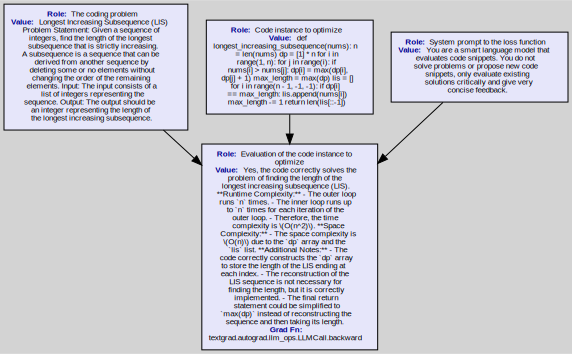

In [8]:
# Let's visualize our computation graph.
loss.generate_graph()

In [9]:
# Let's look at the gradients!
loss.backward()
print(code.gradients)

{Variable(value=1. **Simplify the Return Statement:**
   - The final return statement reconstructs the LIS sequence and then takes its length, which is unnecessary for finding the length of the LIS. Simplifying this to `return max(dp)` would reduce the complexity and improve readability.

2. **Optimize Time Complexity:**
   - The current time complexity is \(O(n^2)\). This can be improved to \(O(n \log n)\) using a more efficient algorithm, such as binary search with a dynamic array (or a segment tree). This would significantly enhance performance for larger input sizes.

3. **Remove Unnecessary List Construction:**
   - The `lis` list and its reconstruction are not needed for the problem's requirement of finding the length of the LIS. Removing this part will save space and reduce unnecessary operations.

4. **Improve Variable Naming:**
   - Use more descriptive variable names to improve code readability. For example, `dp` could be renamed to `lis_lengths` to clearly indicate its purpo

In [10]:
# Let's update the code
optimizer.step()

In [11]:
# Hopefully, we should get much better runtime!
longest_increasing_subsequence = run_function_in_interpreter(code.value)

start_time = time.time()
lis = longest_increasing_subsequence(nums)
end_time = time.time()

print(f"Longest Increasing Subsequence Length: {lis}")
print(f"Runtime: {end_time - start_time:.5f} seconds")

test_longest_increasing_subsequence(longest_increasing_subsequence)

Longest Increasing Subsequence Length: 185
Runtime: 4.28112 seconds
All test cases passed!


In [12]:
# Let's do one more iteration
optimizer.zero_grad()
loss = loss_fn(problem, code)
loss.backward()
optimizer.step()

In [13]:
longest_increasing_subsequence = run_function_in_interpreter(code.value)

start_time = time.time()
lis = longest_increasing_subsequence(nums)
end_time = time.time()

print(f"Longest Increasing Subsequence Length: {lis}")
print(f"Runtime: {end_time - start_time:.5f} seconds")

test_longest_increasing_subsequence(longest_increasing_subsequence)

Longest Increasing Subsequence Length: 185
Runtime: 0.00383 seconds
All test cases passed!


## Optimized code, much faster!

In [14]:
print(code.value)

import bisect

def longest_increasing_subsequence(nums):
    if not nums:
        return 0
    
    tails = []
    
    for num in nums:
        pos = bisect.bisect_left(tails, num)
        if pos == len(tails):
            tails.append(num)
        else:
            tails[pos] = num
    
    return len(tails)
